<a href="https://colab.research.google.com/github/AdrianEspitiaUN/ML-projects/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Esta entrega está incompleta, subo el notebook pero espero poder modificarlo antes de la revisión :c

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%shell
if ! command -v julia 3>&1 > /dev/null
then
    wget -q 'https://julialang-s3.julialang.org/bin/linux/x64/1.8/julia-1.8.5-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    file /tmp/julia.tar.gz
    #tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    #rm /tmp/julia.tar.gz
fi
#julia -e 'using Pkg; pkg"add IJulia; precompile;"'
#echo 'Done'

/tmp/julia.tar.gz: empty


Next cell copies Julia to Drive (it's not necessary to execute it again)

In [ ]:
#cp("/root/.julia", "/content/drive/MyDrive/Julia/", force=true

"/content/drive/MyDrive/Julia/"

In [ ]:
using Pkg
Pkg.add.(["DataFrames","CSV","RDatasets","MLUtils","ZipFile","Metrics","HTTP",
"Optim","MLJ","LIBSVM","MLJLIBSVMInterface","CategoricalArrays","MLJModels", "MLJDecisionTreeInterface", "EvalMetrics", "PyPlot", "MLJFlux"])

SyntaxError: ignored

In [ ]:
Pkg.add("MLJFlux")

   Resolving package versions...
   Installed cuDNN ────────────────── v1.0.2
   Installed BFloat16s ────────────── v0.4.2
   Installed CEnum ────────────────── v0.4.2
   Installed Optimisers ───────────── v0.2.17
   Installed TimerOutputs ─────────── v0.5.22
   Installed NNlibCUDA ────────────── v0.2.7
   Installed MLJFlux ──────────────── v0.2.9
   Installed GPUArrays ────────────── v8.6.5
   Installed CUDA_Runtime_jll ─────── v0.4.0+2
   Installed RealDot ──────────────── v0.1.0
   Installed Functors ─────────────── v0.4.4
   Installed CUDA_Driver_jll ──────── v0.4.0+2
   Installed IRTools ──────────────── v0.4.9
   Installed ProgressLogging ──────── v0.1.4
   Installed RandomNumbers ────────── v1.5.3
   Installed CUDA_Runtime_Discovery ─ v0.1.2
   Installed OneHotArrays ─────────── v0.2.3
   Installed Metalhead ────────────── v0.7.4
   Installed LLVM ─────────────────── v4.17.1
   Installed UnsafeAtomicsLLVM ────── v0.1.1
   Installed Random123 ────────────── v1.6.0
   Installed Zy

In [ ]:
using EvalMetrics

[ Info: Precompiling EvalMetrics [251d5f9e-10c1-4699-ba24-e0ad168fa3e4]
┌ Warning: Module DocStringExtensions with build ID 923891771892 is missing from the cache.
│ This may mean DocStringExtensions [ffbed154-4ef7-542d-bbb7-c09d3a79fcae] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
[ Info: Skipping precompilation since __precompile__(false). Importing EvalMetrics [251d5f9e-10c1-4699-ba24-e0ad168fa3e4].


In [ ]:
using Random
using LinearAlgebra
using RDatasets
using DataFrames
using CSV
using MLUtils
using ZipFile
using Metrics
using HTTP
using Optim
using MLJ
using CategoricalArrays
using EvalMetrics

# Datasets

This is a classification problem, more precisely, a binary classification problem. On the first dataset we have two classes: 1 or 0, depending whether the banknote is authentic or not. The features in this case are some values obtained from the Wavelet transform image from each bancknote picture. For example, variance and skewness of the Wavelet image.

The second dataset has as features some measurements taken from a room (humidity, temperature, etc.) and a label which indicates whether the room is occupied or not.

In the banknotes dataset problem, the classifyier is probably required to target fake banknotes, so any model should put emphasis in reducing the number of false negatives in the fake banknotes class. Thus, the performance measures to assess models trained on this dataset are precision and recall of the fake banknotes class.

On the other hand, there is not an apparent interest in any of the two classes for the occupancy problem. Since the researchers that collected the data chose to take as performance measure the precision of the "occupied" class, we will do so as well.

In [ ]:
#Dataset1
DS1 = CSV.read(download("https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"), DataFrame, header=false)
replace!(DS1[!,5], 0 => -1); #Change 0 to -1 for the negative class, since we are using SVM

In [ ]:
#Dataset2
#This dataset is already partitioned into training, test and validation 
datafile="https://archive.ics.uci.edu/ml/machine-learning-databases/00357/occupancy_data.zip"
dat = HTTP.get(datafile)
r = ZipFile.Reader(IOBuffer(dat.body))
f1  = r.files[1] 
f2  = r.files[2]
f3  = r.files[3]
DS2test1 = CSV.read(f1, DataFrame, header = ["num", "date", "Temperature", "Humidity", "Light", "CO2", "HumidityRatio", "Occupancy"], skipto = 2) 
DS2test2 = CSV.read(f2, DataFrame, header = ["num", "date", "Temperature", "Humidity", "Light", "CO2", "HumidityRatio", "Occupancy"], skipto = 2)
DS2train = CSV.read(f3, DataFrame, header = ["num", "date", "Temperature", "Humidity", "Light", "CO2", "HumidityRatio", "Occupancy"], skipto = 2)
replace!(DS2train[!,"Occupancy"], 0 => -1)
replace!(DS2test1[!,"Occupancy"], 0 => -1)
replace!(DS2test2[!,"Occupancy"], 0 => -1);


In [ ]:
DS2trainX, DS2trainY = DS2train[:,3:end-1] , CategoricalVector(DS2train[!, "Occupancy"], ordered = true, levels = [1,-1])
DS2test1X, DS2test1Y = DS2test1[:,3:end-1] , CategoricalVector(DS2test1[!, "Occupancy"], ordered = true, levels = [1,-1])
DS2test2X, DS2test2Y = DS2test2[:,3:end-1] , CategoricalVector(DS2test2[!, "Occupancy"], ordered = true, levels = [1,-1])

(9752×5 DataFrame
  Row │ Temperature  Humidity  Light    CO2      HumidityRatio 
      │ Float64      Float64   Float64  Float64  Float64       
──────┼────────────────────────────────────────────────────────
    1 │     21.76     31.1333  437.333  1029.67     0.00502101
    2 │     21.79     31.0     437.333  1000.0      0.00500858
    3 │     21.7675   31.1225  434.0    1003.75     0.00502157
    4 │     21.7675   31.1225  439.0    1009.5      0.00502157
    5 │     21.79     31.1333  437.333  1005.67     0.0050303
    6 │     21.76     31.26    437.333  1014.33     0.0050416
    7 │     21.79     31.1975  434.0    1018.5      0.00504075
    8 │     21.79     31.3933  437.333  1018.67     0.00507265
    9 │     21.79     31.3175  434.0    1022.0      0.0050603
   10 │     21.79     31.4633  437.333  1027.33     0.00508405
   11 │     21.79     31.525   437.75   1047.75     0.0050941
  ⋮   │      ⋮          ⋮         ⋮        ⋮           ⋮
 9743 │     20.79     26.745    50.75   1463

#SVM

In [ ]:
function SVMtrain(data)
  tol = 0.08
  xtrain = Matrix(data[1])
  ytrain = data[2]
  size_data, dim_data = size(xtrain)
  transforms = ones(dim_data, 2^dim_data)
  opt_dict = Dict()
  opt_w = ones(dim_data)
  opt_b = 0

  for i = 1:dim_data
    tr = replace!(digits(i, base=2, pad=2^dim_data), 0=>-1)
    transforms[i,:] = tr
  end

  max_feature_value = maximum(xtrain)

  step_sizes =[max_feature_value * 0.1,
                      max_feature_value * 0.01,
                      max_feature_value * 0.001]
  
  b_range = 5*max_feature_value
  b_multiple = 5


  latest_optimum = max_feature_value*10

  for step in step_sizes
    w = latest_optimum*ones(dim_data)
    optimized = false 
    while !optimized
      b_step = step*b_multiple
      for b =-1*b_range:b_step:b_range
        for transformation in transforms
          w_t = w.*transformation
          found_option = true
          misses = 0
          for i = 1:size_data
            xi = xtrain[i,:]
            yi = ytrain[i]
            if !(yi*(w_t'*xi-b) >= 1)
              misses += 1
            end
          end
          err_percent = misses/size_data

          if err_percent > tol
            found_option = false
          end

          if found_option
          
            opt_dict[norm(w_t)] = [w_t, b]
          end
        end
      end
      if w[1] < 0
        optimized = true
        println("optimized a step")
      else
      w = w.-step
      end
      opt_choice = opt_dict[minimum(keys(opt_dict))]
      opt_w, opt_b= opt_choice
      latest_optimum = opt_choice[1][1] + step*2
    end
  end
  return opt_w, opt_b
end

function SVMpredict(x, svm)
  y = x*svm[1] .+ svm[2]
  return sign.(y)
end

SVMpredict (generic function with 1 method)

Next, the dataset is splitted into train and test datasets

In [ ]:
Random.seed!(1234)


X1, Y1 = DS1[:,1:4], DS1[:,5]
Xs, Ys = shuffleobs((X1,Y1))

train, val, test = splitobs((Xs,Ys), at = (0.7, 0.2))

((ObsView(::DataFrame, ::Vector{Int64})
 960 observations, [1, -1, 1, -1, 1, -1, 1, 1, -1, -1  …  -1, -1, -1, 1, -1, 1, -1, -1, -1, -1]), (ObsView(::DataFrame, ::Vector{Int64})
 274 observations, [-1, -1, -1, 1, 1, 1, -1, -1, 1, -1  …  -1, -1, -1, 1, -1, -1, -1, -1, 1, -1]), (ObsView(::DataFrame, ::Vector{Int64})
 138 observations, [1, 1, 1, -1, 1, -1, -1, 1, 1, -1  …  -1, 1, -1, -1, 1, 1, 1, -1, 1, -1]))

In [ ]:
svm_instatance = SVMtrain(getobs(train)) 

optimized a step
optimized a step
optimized a step


([-3.1818960000002208, -3.1818960000002208, -3.1818960000002208, -3.1818960000002208], -1.679334)

In [ ]:
set_encoding(OneMinusOne(:positive,:negative))
ypred = SVMpredict(Matrix(getobs(test)[1]), svm_instatance)
binary_eval_report(getobs(test)[2], ypred)

LoadError: ignored

#SVM soft margin


A continuación implementamos una SVM con margen suave para lidiar con el posible ruido.

In [ ]:
function SMSVMcost(data, wb)
  C = 1
  x = Matrix(data[1])
  y = data[2]
  w = wb[1:end-1]
  b = wb[end]
  sm = 0
  errors = 0
  for i = 1:size(y)[1]
    if maximum([0, 1-y[i]*(w'*x[i,:]-b)]) != 0
      errors +=1
    end
    sm += maximum([0, 1-y[i]*(w'*x[i,:]-b)])
  end
  return norm(w)^2 + 100*sm/(size(y)[1])
end

function trainSMSVM(data)
  xtrain = Matrix(data[1])
  size_data, dim_data = size(xtrain)
  f(wb) = SMSVMcost(data, wb)
  wb_0 = ones(dim_data+1)
  wb_0[end] = 100
  opt = optimize(f, wb_0)
  opt_wb = Optim.minimizer(opt)
  return opt_wb[1:end-1], opt_wb[end], opt
end


trainSMSVM (generic function with 1 method)

In [ ]:
svm_instance = trainSMSVM(getobs(train)) 

([-0.8620007692408539, -0.5526138316818414, -0.6291343311565154, -0.015980396433498602], -1.2733906938250752,  * Status: success

 * Candidate solution
    Final objective value:     5.228951e+00

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   3  (vs limit Inf)
    Iterations:    644
    f(x) calls:    1082
)

In [ ]:
#ypred = SVMpredict(Matrix(getobs(train)[1]), svm_instance)
wb = vcat(svm_instance[1], [svm_instance[2]])
SMSVMcost(getobs(train), wb)

5.228950952285903

In [ ]:
getobs(test)[2]

138-element Vector{Int64}:
  1
  1
  1
 -1
  1
 -1
 -1
  1
  1
 -1
  1
 -1
 -1
  ⋮
  1
  1
 -1
  1
 -1
 -1
  1
  1
  1
 -1
  1
 -1

#Library SVM

In [ ]:
doc("LinearSVC", pkg="LIBSVM")

```
LinearSVC
```

A model type for constructing a linear support vector classifier, based on [LIBSVM.jl](https://github.com/mpastell/LIBSVM.jl), and implementing the MLJ model interface.

From MLJ, the type can be imported using

```
LinearSVC = @load LinearSVC pkg=LIBSVM
```

Do `model = LinearSVC()` to construct an instance with default hyper-parameters. Provide keyword arguments to override hyper-parameter defaults, as in `LinearSVC(solver=...)`.

Reference for algorithm and core C-library: Rong-En Fan et al (2008): "LIBLINEAR: A Library for Large Linear Classification." *Journal of Machine Learning Research* 9 1871-1874. Available at [https://www.csie.ntu.edu.tw/~cjlin/papers/liblinear.pdf](https://www.csie.ntu.edu.tw/~cjlin/papers/liblinear.pdf). 

This model type is similar to `SVC` from the same package with the setting `kernel=LIBSVM.Kernel.KERNEL.Linear`, but is optimized for the linear case.

# Training data

In MLJ or MLJBase, bind an instance `model` to data with one of:

```
mach = machine(model, X, y)
mach = machine(model, X, y, w)
```

where

  * `X`: any table of input features (eg, a `DataFrame`) whose columns each have `Continuous` element scitype; check column scitypes with `schema(X)`
  * `y`: is the target, which can be any `AbstractVector` whose element scitype is `<:OrderedFactor` or `<:Multiclass`; check the scitype with `scitype(y)`
  * `w`: a dictionary of class weights, keyed on `levels(y)`.

Train the machine using `fit!(mach, rows=...)`.

# Hyper-parameters

  * `solver=LIBSVM.Linearsolver.L2R_L2LOSS_SVC_DUAL`: linear solver, which must be one of the following from the LIBSVM.jl package:

      * `LIBSVM.Linearsolver.L2R_LR`: L2-regularized logistic regression (primal))
      * `LIBSVM.Linearsolver.L2R_L2LOSS_SVC_DUAL`: L2-regularized L2-loss support vector classification (dual)
      * `LIBSVM.Linearsolver.L2R_L2LOSS_SVC`: L2-regularized L2-loss support vector classification (primal)
      * `LIBSVM.Linearsolver.L2R_L1LOSS_SVC_DUAL`: L2-regularized L1-loss support vector classification (dual)
      * `LIBSVM.Linearsolver.MCSVM_CS`: support vector classification by Crammer and Singer) `LIBSVM.Linearsolver.L1R_L2LOSS_SVC`: L1-regularized L2-loss support vector classification)
      * `LIBSVM.Linearsolver.L1R_LR`:  L1-regularized logistic regression
      * `LIBSVM.Linearsolver.L2R_LR_DUAL`: L2-regularized logistic regression (dual)
  * `tolerance::Float64=Inf`: tolerance for the stopping criterion;
  * `cost=1.0` (range (0, `Inf`)): the parameter denoted $C$ in the cited reference; for greater regularization, decrease `cost`
  * `bias= -1.0`: if `bias >= 0`, instance `x` becomes `[x; bias]`; if `bias < 0`, no bias term added (default -1)

# Operations

  * `predict(mach, Xnew)`: return predictions of the target given features `Xnew` having the same scitype as `X` above.

# Fitted parameters

The fields of `fitted_params(mach)` are:

  * `libsvm_model`: the trained model object created by the LIBSVM.jl package
  * `encoding`: class encoding used internally by `libsvm_model` - a dictionary of class labels keyed on the internal integer representation

# Examples

```
using MLJ
import LIBSVM

LinearSVC = @load LinearSVC pkg=LIBSVM               # model type
model = LinearSVC(solver=LIBSVM.Linearsolver.L2R_LR) # instance

X, y = @load_iris # table, vector
mach = machine(model, X, y) |> fit!

Xnew = (sepal_length = [6.4, 7.2, 7.4],
        sepal_width = [2.8, 3.0, 2.8],
        petal_length = [5.6, 5.8, 6.1],
        petal_width = [2.1, 1.6, 1.9],)

julia> yhat = predict(mach, Xnew)
3-element CategoricalArrays.CategoricalArray{String,1,UInt32}:
 "virginica"
 "versicolor"
 "virginica"
```

## Incorporating class weights

```julia
weights = Dict("virginica" => 1, "versicolor" => 20, "setosa" => 1)
mach = machine(model, X, y, weights) |> fit!

julia> yhat = predict(mach, Xnew)
3-element CategoricalArrays.CategoricalArray{String,1,UInt32}:
 "versicolor"
 "versicolor"
 "versicolor"
```

See also the [`SVC`](@ref) and [`NuSVC`](@ref) classifiers, and [LIVSVM.jl](https://github.com/JuliaML/LIBSVM.jl) and the original C implementation [documentation](https://github.com/cjlin1/liblinear/blob/master/README).


In [ ]:
LinearSVC = @load LinearSVC pkg=LIBSVM

model = LinearSVC(solver=LIBSVM.Linearsolver.L2R_LR)

SMSVM = machine(model, DS2trainX, DS2trainY) |> fit!

import MLJLIBSVMInterface ✔


[ Info: For silent loading, specify `verbosity=0`. 
[ Info: Training machine(LinearSVC(solver = L2R_LR, …), …).


trained Machine; caches model-specific representations of data
  model: LinearSVC(solver = L2R_LR, …)
  args: 
    1:	Source @868 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @753 ⏎ AbstractVector{OrderedFactor{2}}


In [ ]:
Ypred = predict(SMSVM, DS2test1X)

MLJ.confusion_matrix(Ypred, DS2test1Y)

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │     -1      │
├─────────────┼─────────────┼─────────────┤
│      1      │     969     │     55      │
├─────────────┼─────────────┼─────────────┤
│     -1      │      3      │    1638     │
└─────────────┴─────────────┴─────────────┘


#Decision Tree

A first approach to evaluate the separability of the data is to look at the distribution of the points as shown in their histograms.

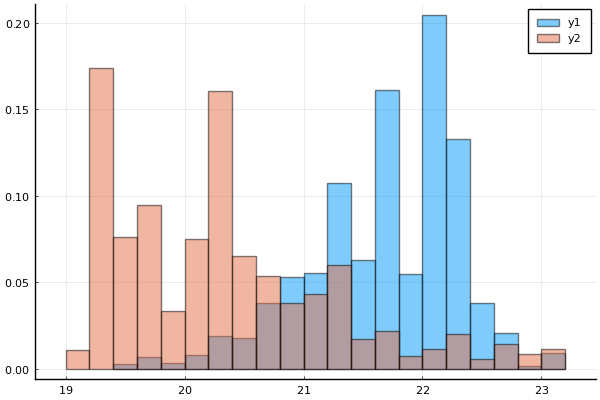

In [ ]:
histogram(DS2train[DS2train.Occupancy .== 1, "Temperature"], alpha=0.5, normalize=:probability)
histogram!(DS2train[DS2train.Occupancy .== -1, "Temperature"], alpha=0.5, normalize=:probability)

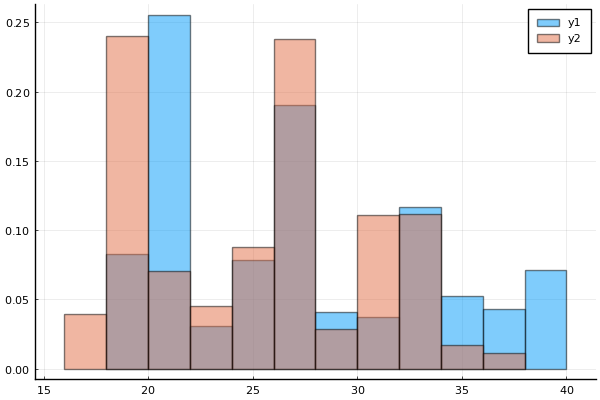

In [ ]:
histogram(DS2train[DS2train.Occupancy .== 1, "Humidity"], alpha=0.5, normalize=:probability)
histogram!(DS2train[DS2train.Occupancy .== -1, "Humidity"], alpha=0.5, normalize=:probability)

For instance, the feature "Temperature" seems to separate the classes better that the feature "Humidity"

Based on https://towardsdatascience.com/part-ii-using-a-decision-tree-ddffa4004e47

In [ ]:
MyDecisionTree = @load DecisionTreeClassifier pkg = "DecisionTree"
dc = MyDecisionTree()

import MLJDecisionTreeInterface ✔


[ Info: For silent loading, specify `verbosity=0`. 


DecisionTreeClassifier(
  max_depth = -1, 
  min_samples_leaf = 1, 
  min_samples_split = 2, 
  min_purity_increase = 0.0, 
  n_subfeatures = 0, 
  post_prune = false, 
  merge_purity_threshold = 1.0, 
  display_depth = 5, 
  feature_importance = :impurity, 
  rng = Random._GLOBAL_RNG())

In [ ]:
DS1Y, DS1X = unpack(DS1, ==(:Column5), rng = 123) #Separates X and Y and shuffles the rows
DS1Y = CategoricalVector(DS1Y, ordered=true, levels=[1,-1])
(Xtrain, Xtest), (Ytrain, Ytest) =  partition((DS1X, DS1Y), 0.7, multi = true, rng = 123);

In [ ]:
dc_mach = machine(dc, Xtrain, Ytrain)
fit!(dc_mach)

[ Info: Training machine(DecisionTreeClassifier(max_depth = -1, …), …).


trained Machine; caches model-specific representations of data
  model: DecisionTreeClassifier(max_depth = -1, …)
  args: 
    1:	Source @599 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @042 ⏎ AbstractVector{OrderedFactor{2}}


In [ ]:
Ypred = predict_mode(dc_mach, Xtest)
MLJ.confusion_matrix(Ypred, Ytest)

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │     -1      │
├─────────────┼─────────────┼─────────────┤
│      1      │     175     │      5      │
├─────────────┼─────────────┼─────────────┤
│     -1      │      4      │     228     │
└─────────────┴─────────────┴─────────────┘


#Linear separability

In [ ]:

Perceptron = @load NeuralNetworkClassifier pkg = MLJLinearModels

[ Info: For silent loading, specify `verbosity=0`. 


LoadError: ignored

In [ ]:
clf = NeuralNetworkClassifier()

LoadError: ignored